In [4]:
#模拟数据生成
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 生成货币资金模拟数据（银行流水）
np.random.seed(42)
dates = [datetime(2023, 1, 1) + timedelta(days=i) for i in range(100)]
bank_data = pd.DataFrame({
    "日期": np.random.choice(dates, 200),
    "凭证号": ["INV" + str(np.random.randint(1000, 9999)) for _ in range(200)],
    "对方账户": np.random.choice(["客户A", "客户B", "供应商X", "个人账户"], 200),
    "交易类型": np.random.choice(["收入", "支出"], 200, p=[0.6, 0.4]),
    "金额": np.round(np.abs(np.random.normal(50000, 30000, 200)), 2),
    "摘要": np.random.choice(["货款", "费用报销", "工资", "其他"], 200)
})

# 插入异常数据：重复凭证号和大额交易
bank_data.loc[199] = ["2023-12-31", "INV1234", "未知账户", "支出", 2000000.00, "异常大额支出"]

# 生成应收账款模拟数据
ar_data = pd.DataFrame({
    "客户名称": np.random.choice(["客户A", "客户B", "客户C", "客户D"], 50),
    "发票日期": np.random.choice(dates, 50),
    "到期日": [d + timedelta(days=30) for d in np.random.choice(dates, 50)],
    "金额": np.round(np.abs(np.random.normal(100000, 50000, 50)), 2),
    "已偿还金额": lambda x: np.round(x["金额"] * np.random.uniform(0, 0.8, 50), 2),
    "是否逾期": np.random.choice([True, False], 50, p=[0.2, 0.8])
})

# 导出为Excel文件
with pd.ExcelWriter("audit_data.xlsx") as writer:
    bank_data.to_excel(writer, sheet_name="银行流水", index=False)
    ar_data.to_excel(writer, sheet_name="应收账款", index=False)

In [5]:
# 货币资金审计自动化
#一、数据清洗与预处理
#读取银行流水数据
bank_df = pd.read_excel("audit_data.xlsx", sheet_name="银行流水")

# 数据清洗
bank_df["日期"] = pd.to_datetime(bank_df["日期"])  # 统一日期格式
bank_df["金额"] = bank_df["金额"].abs()          # 金额取正数

# 检查重复凭证号（关键审计程序）
duplicate_invoices = bank_df[bank_df.duplicated("凭证号", keep=False)].sort_values("凭证号")
print("重复凭证号交易：\n", duplicate_invoices)

重复凭证号交易：
             日期      凭证号  对方账户 交易类型         金额    摘要
35  2023-03-21  INV3327   客户A   收入   39476.32    工资
130 2023-02-02  INV3327   客户A   支出   23755.80  费用报销
77  2023-04-03  INV4170   客户A   收入   19938.60    工资
134 2023-03-29  INV4170   客户A   收入   78977.66    工资
42  2023-02-24  INV7287   客户B   支出  121229.88  费用报销
69  2023-02-05  INV7287  个人账户   收入   34022.59    其他


In [6]:
# 二、大额交易识别
# 定义大额阈值（例如：金额 > 3σ）
threshold = bank_df["金额"].mean() + 3 * bank_df["金额"].std()
large_transactions = bank_df[bank_df["金额"] > threshold]
print("大额交易预警：\n", large_transactions[["日期","凭证号","对方账户","金额"]])

大额交易预警：
             日期      凭证号  对方账户         金额
199 2023-12-31  INV1234  未知账户  2000000.0


D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38134 (\N{CJK UNIFIED IDEOGRAPH-94F6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Li

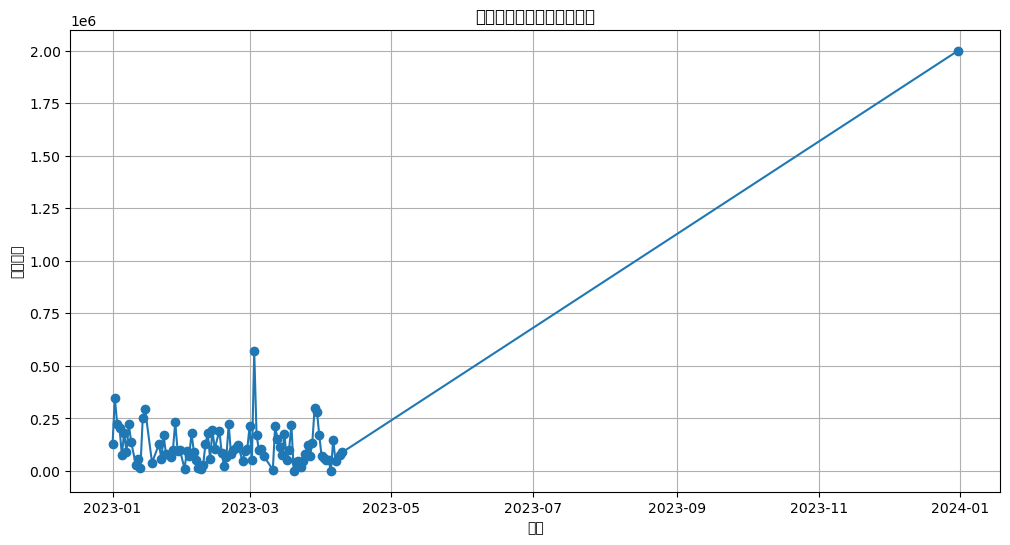

In [7]:
# 银行流水波动分析

import matplotlib.pyplot as plt

# 按日汇总交易金额
daily_flow = bank_df.groupby("日期")["金额"].sum().reset_index()

# 绘制资金流动趋势图
plt.figure(figsize=(12, 6))
plt.plot(daily_flow["日期"], daily_flow["金额"], marker='o')
plt.title("银行账户每日资金流动趋势")
plt.xlabel("日期")
plt.ylabel("交易总额")
plt.grid(True)
plt.show()

In [8]:
# 三应收账款审计自动化
# 1.账龄分析
from datetime import datetime

# 计算账龄（截至2023-12-31）
cutoff_date = datetime(2023, 12, 31)
ar_df = pd.read_excel("audit_data.xlsx", sheet_name="应收账款")
ar_df["账龄天数"] = (cutoff_date - ar_df["到期日"]).dt.days
ar_df["账龄区间"] = pd.cut(ar_df["账龄天数"], 
                         bins=[0, 30, 60, 90, np.inf],
                         labels=["0-30天", "31-60天", "61-90天", "90天以上"])

# 按账龄分类汇总
aging_summary = ar_df.groupby("账龄区间")["金额"].agg(['sum', 'count'])
print("应收账款账龄分析：\n", aging_summary)

应收账款账龄分析：
                sum  count
账龄区间                     
0-30天         0.00      0
31-60天        0.00      0
61-90天        0.00      0
90天以上   5175458.81     50


C:\Users\荒糖\AppData\Local\Temp\ipykernel_2704\2069159762.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aging_summary = ar_df.groupby("账龄区间")["金额"].agg(['sum', 'count'])


In [9]:
#2.客户集中度分析
# 计算前三大客户占比
client_concentration = ar_df.groupby("客户名称")["金额"].sum().nlargest(3)
total_receivables = ar_df["金额"].sum()
top3_percent = client_concentration / total_receivables * 100
print("客户集中度风险：\n", top3_percent)

客户集中度风险：
 客户名称
客户D    26.932734
客户C    25.471097
客户A    25.385025
Name: 金额, dtype: float64


In [10]:
# 坏账准备测算
# 根据账龄计提比例（假设：0-30天0%，31-60天5%，61-90天20%，90天以上50%）
def calculate_provision(row):
    if row["账龄区间"] == "0-30天":
        return 0
    elif row["账龄区间"] == "31-60天":
        return row["金额"] * 0.05
    elif row["账龄区间"] == "61-90天":
        return row["金额"] * 0.20
    else:
        return row["金额"] * 0.50

ar_df["坏账准备"] = ar_df.apply(calculate_provision, axis=1)
total_provision = ar_df["坏账准备"].sum()
print(f"建议计提坏账准备总额：{total_provision:,.2f}元")

建议计提坏账准备总额：2,587,729.40元


In [11]:
# 四 生成审计底稿
# 创建审计结果汇总表
from pandas.io.formats.style import Styler

with pd.ExcelWriter("审计底稿输出.xlsx") as writer:
    # 货币资金异常交易
    duplicate_invoices.to_excel(writer, sheet_name="重复凭证号", index=False)
    large_transactions.to_excel(writer, sheet_name="大额交易", index=False)
    
    # 应收账款分析
    aging_summary.reset_index().to_excel(writer, sheet_name="账龄分析", index=False)
    ar_df.to_excel(writer, sheet_name="坏账计提明细", index=False)
    
    # 添加格式（突出显示高风险项）
    workbook = writer.book
    format_red = workbook.add_format({"bg_color": "#FFC7CE"})
    
    sheet = writer.sheets["坏账计提明细"]
    sheet.conditional_format('G2:G100', {
        'type': 'cell',
        'criteria': '>=',
        'value': 100000,
        'format': format_red
    })

AttributeError: 'Workbook' object has no attribute 'add_format'

In [12]:
#五 审计程序扩展建议
#1.机器学习
# 使用孤立森林检测异常交易
from sklearn.ensemble import IsolationForest
model = IsolationForest(contamination=0.05)
bank_df["异常评分"] = model.fit_predict(bank_df[["金额"]])
anomalies = bank_df[bank_df["异常评分"] == -1]
#2 自动化对账
# 对比企业账面余额与银行对账单
book_balance = 15000000  # 假设账面余额
bank_statement_balance = bank_df.groupby("交易类型")["金额"].sum()
calculated_balance = book_balance + bank_statement_balance.get("收入", 0) - bank_statement_balance.get("支出", 0)
print(f"调节后余额差异：{calculated_balance - book_balance:,.2f}元")


调节后余额差异：-1,335,338.12元


D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39318 (\N{CJK UNIFIED IDEOGRAPH-9996}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Li

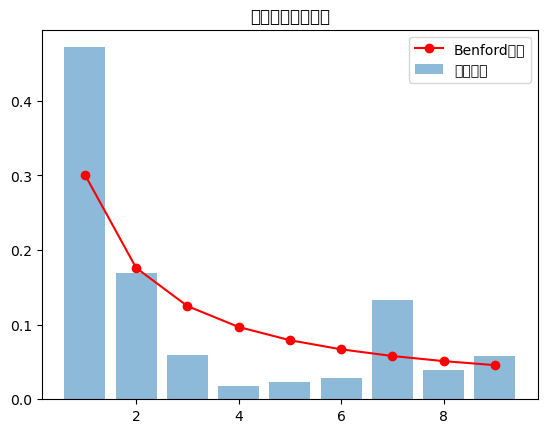

卡方检验P值: 1.0000


In [13]:
# 费用报销异常检测Benford定律）
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 生成模拟数据（包含正常报销和人为修改的异常数据）
np.random.seed(42)
normal_amounts = np.round(np.random.lognormal(mean=5, sigma=0.5, size=900), 2)  # 自然生成金额（900笔）
fraud_amounts = [700.00, 750.00, 780.00] * 30  # 人为设定以7开头的金额（90笔）
all_amounts = np.concatenate([normal_amounts, fraud_amounts])

# 计算首位数字分布
first_digits = pd.Series(all_amounts).astype(str).str[0].replace({'0':np.nan}).dropna().astype(int)
observed = first_digits.value_counts(normalize=True).sort_index()

# 本福特定律理论分布
benford = np.log10(1 + 1/np.arange(1,10))
expected = pd.Series(benford, index=range(1,10))

# 可视化对比
plt.bar(observed.index, observed, alpha=0.5, label='实际分布')
plt.plot(expected.index, expected, 'r-', marker='o', label='Benford理论')
plt.title("首位数字分布对比")
plt.legend()
plt.show()

# 卡方检验差异显著性
from scipy.stats import chisquare
chi_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print(f"卡方检验P值: {p_value:.4f}")  # P<0.05说明存在显著异常

In [14]:
# 存货监盘差异分析
import pandas as pd
from scipy.stats import ttest_rel

# 假设有10个存货项目的自盘和监盘数量
data = {
    'Item': ['A001', 'A002', 'A003', 'A004', 'A005', 'A006', 'A007', 'A008', 'A009', 'A010'],
    '自盘数量': [100, 150, 200, 80, 300, 250, 180, 90, 120, 210],
    '监盘数量': [98, 148, 202, 79, 305, 248, 182, 91, 118, 208]
}
df = pd.DataFrame(data)

# 计算差异百分比
df['差异率'] = (df['监盘数量'] - df['自盘数量']) / df['自盘数量'] * 100

# 单样本t检验（假设平均差异为0）
t_stat, p_value = ttest_rel(df['监盘数量'], df['自盘数量'])
print(f"T统计量: {t_stat:.2f}, P值: {p_value:.4f}")

# 判断标准（α=0.05）
if p_value < 0.05:
    print("存在显著差异，需扩大监盘范围！")
else:
    print("差异在合理范围内。")

T统计量: -0.13, P值: 0.9009
差异在合理范围内。


In [15]:
# 收入确认截期测试
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp

# 生成模拟收入数据（含异常集中在12月31日的交易）
dates = pd.date_range('2023-01-01', '2023-12-31', freq='D')
np.random.seed(42)
normal_dates = np.random.choice(dates[:-1], 200, p=np.ones(len(dates)-1)/(len(dates)-1))  # 正常日期
fraud_dates = [pd.Timestamp('2023-12-31')] * 30  # 12月31日异常交易
all_dates = np.concatenate([normal_dates, fraud_dates])

# 提取交易日期中的“月-日”格式（排除年份影响）
transactions = pd.Series(all_dates).dt.strftime('%m-%d')

# 计算每日交易频次
daily_counts = transactions.value_counts().sort_index()

# Kolmogorov-Smirnov检验：比较12月与非12月交易分布
dec_dates = [d for d in all_dates if d.month == 12]
non_dec_dates = [d for d in all_dates if d.month != 12]
stat, p_value = ks_2samp(dec_dates, non_dec_dates)
print(f"KS检验P值: {p_value:.4f}")

# 可视化
plt.figure(figsize=(12,4))
daily_counts.plot(kind='line')
plt.axvline('12-31', color='red', linestyle='--', label='12月31日')
plt.title("全年每日交易频次分布")
plt.xticks(rotation=90)
plt.show()

AttributeError: Can only use .dt accessor with datetimelike values

In [16]:
# 应付账款周转率异常( S-score标准化
import pandas as pd
import numpy as np

# 模拟供应商付款周期数据（天）
np.random.seed(42)
normal_days = np.random.normal(loc=60, scale=10, size=50)  # 正常供应商（均值60天）
fraud_days = [30, 25, 28, 90, 95]  # 异常供应商（过短或过长）
all_days = np.concatenate([normal_days, fraud_days])
suppliers = [f"Sup_{i+1}" for i in range(len(all_days))]

# 计算Z-score
mean = np.mean(all_days)
std = np.std(all_days)
z_scores = (all_days - mean) / std

# 标记异常（|Z|>2）
df = pd.DataFrame({'Supplier': supplers, 'Days': all_days, 'Z-score': z_scores})
df['异常'] = np.abs(df['Z-score']) > 2

print("异常供应商列表：")
print(df[df['异常']])

NameError: name 'supplers' is not defined

D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32852 (\N{CJK UNIFIED IDEOGRAPH-8054}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22336 (\N{CJK UNIFIED IDEOGRAPH-5740}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Li

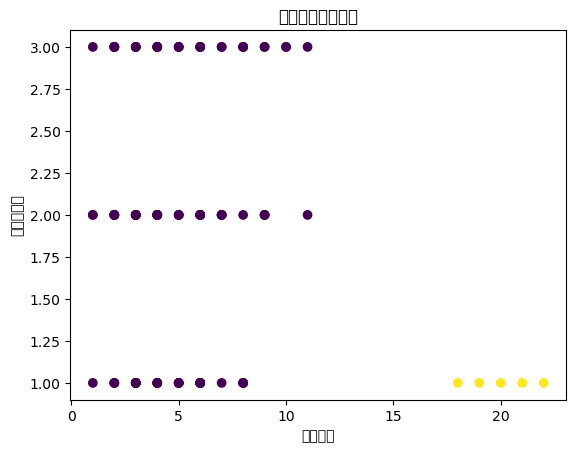

独立异常客户：
 Empty DataFrame
Columns: [客户, 交易次数, 关联地址数, Cluster]
Index: []

异常客户集群：
      客户  交易次数  关联地址数  Cluster
0    C0     4      2        0
1    C1     1      3        0
2    C2     6      1        0
3    C3     4      3        0
4    C4     6      2        0
..  ...   ...    ...      ...
90  C90     3      3        0
91  C91     3      3        0
92  C92     5      2        0
93  C93     6      3        0
94  C94     5      3        0

[95 rows x 4 columns]


In [17]:
# 客户交易关联分析 聚类分析
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 模拟客户交易数据（含异常聚类）
data = {
    '客户': [f'C{i}' for i in range(100)],
    '交易次数': np.random.poisson(lam=5, size=100),  # 正常客户交易次数
    '关联地址数': np.random.randint(1, 4, 100),     # 正常客户关联地址数
}
# 插入异常客户（高频交易+相同地址）
data['交易次数'][95:100] = [20, 22, 19, 21, 18]
data['关联地址数'][95:100] = [1, 1, 1, 1, 1]

df = pd.DataFrame(data)

# 聚类分析
X = df[['交易次数', '关联地址数']]
clustering = DBSCAN(eps=3, min_samples=2).fit(X)
df['Cluster'] = clustering.labels_

# 可视化
plt.scatter(df['交易次数'], df['关联地址数'], c=df['Cluster'], cmap='viridis')
plt.xlabel('交易次数')
plt.ylabel('关联地址数')
plt.title("客户交易聚类分析")
plt.show()

# 输出异常集群
anomaly_clusters = df[df['Cluster'] == -1]  # -1表示噪声点（单独个体）
print("独立异常客户：\n", anomaly_clusters)
cluster_0 = df[df['Cluster'] == 0]          # 0号集群（群体异常）
print("\n异常客户集群：\n", cluster_0)

D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24037 (\N{CJK UNIFIED IDEOGRAPH-5DE5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31665 (\N{CJK UNIFIED IDEOGRAPH-7BB1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Li

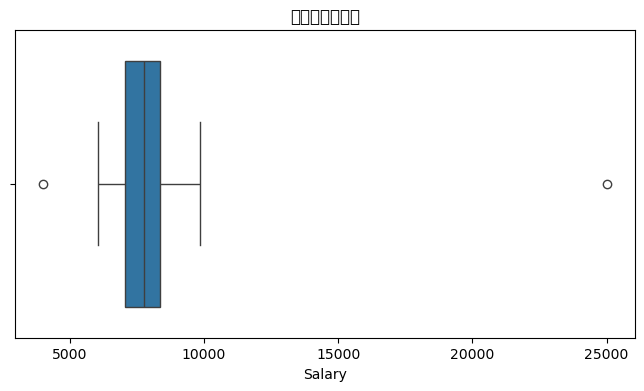

异常工资记录：
    Position   Salary  异常工资
50     异常高薪  25000.0  True
51     异常低薪   4000.0  True


In [18]:
# 工资薪酬合理性检查  箱线图和分位数分析
import pandas as pd
import seaborn as sns

# 生成模拟工资数据（含异常值）
np.random.seed(42)
salaries = np.concatenate([
    np.random.normal(loc=8000, scale=1000, size=50),  # 普通员工
    [25000],  # 异常高薪（高管误计入）
    [4000]    # 异常低薪（实习生误计入）
])
positions = ['普通员工']*50 + ['异常高薪'] + ['异常低薪']

df = pd.DataFrame({'Position': positions, 'Salary': salaries})

# 箱线图分析
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Salary'])
plt.title("工资分布箱线图")
plt.show()

# 计算分位数边界
Q1 = df['Salary'].quantile(0.25)
Q3 = df['Salary'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 标记异常
df['异常工资'] = (df['Salary'] < lower_bound) | (df['Salary'] > upper_bound)
print("异常工资记录：\n", df[df['异常工资']])